In [1]:
import imripy
from imripy import constants as c, merger_system as ms, halo, inspiral, plot_utils as pu, detector
from os.path import exists
import os
import plotting

This notebook loads previously computed stochastic inspirals from folders and processes them to see whether they made a plunge or an inspiral

In [2]:
# Example System
m1 = 1e5 * c.solar_mass_to_pc
m2 = 1.  * c.solar_mass_to_pc

hs = ms.HostSystem(m1)

In [3]:
# Stellar Halo
rho_st = 1.
r_st = 11. * (m1/1e8 / c.solar_mass_to_pc)**(0.58)
alpha = 7./4.
stellarHalo = halo.Spike(rho_st, r_st, alpha, m1)
stellarHalo.rho_spike *= m1 / stellarHalo.mass(r_st)

stellarDiffusion = inspiral.forces.StellarDiffusionAna(hs, stellarHalo)

In [4]:
def load_folder(f):
    """ 
    Returns all files from a folder as a list
    """
    runs = next(os.walk(f), (None, None, []))[2]  # [] if no file
    runs = [os.path.join(f, r) for r in runs]
    print(len(runs), runs[0])
    return runs

In [5]:
runs = load_folder("../runs/inspirals/sd/")
runs73 = load_folder("../runs/inspirals/sd_73/")
runs32 = load_folder("../runs/inspirals/sd_32/")

1327 ../runs/inspirals/sd/sd_5.0e+04_2_2_1711236240.100802.npz
664 ../runs/inspirals/sd_73/sd_73_5.0e+04_13_1_1710924529.176913.npz
439 ../runs/inspirals/sd_32/sd_32_1.0e+03_7_2.npz


In [6]:
def load(runs, a0):
    """ 
    Turns a list of files into a list of EvolutionResults, if the file has a0 in its name
    """
    evs = []
    for r in runs:
        if f"{a0/hs.r_isco:.1e}" in r:
            evs.append(inspiral.Classic.EvolutionResults.load(r, hs, inspiral.Classic.EvolutionOptions()))
    return evs

In [7]:
def preprocess(evs):
    """
    Sometimes the EvolutionResults arrays have weird numerical artefacts that we can remove
    """
    for ev in evs:
        if ev.a[-1] < 0 or ev.e[-1] < 0 or ev.e[-1] > 1:
            ev.a = np.delete(ev.a, -1)
            ev.t = np.delete(ev.t, -1)
            ev.e = np.delete(ev.e, -1)

In [8]:
def count(evs, ax_insp = None, ax_plunge=None, ax_other=None, **kwargs):
    """
    Count the number of inspirals, plunges, and whatever is left over, and optionally plot them on the axes
    
    An inspiral is counted when the semimajor axis drops below 500 r_isco and is above the loss cone,
        a plunge is if it's anywhere below the loss cone
    """
    inspiral, plunge, other = 0, 0, 0
    
    for ev in evs:
        if (ev.a[-1] <= 5e2*hs.r_isco) and (ev.a[-1]*(1. - ev.e[-1]) > 8.*hs.m1):
            inspiral += 1
            if not ax_insp is None:
                pu.plotEvolution(hs, ev, ax_1mea=ax_insp, **kwargs)

        elif ev.a[-1]*(1. - ev.e[-1]) < 8.*hs.m1:
            plunge += 1
            if not ax_plunge is None:
                pu.plotEvolution(hs, ev, ax_1mea=ax_plunge, **kwargs)

        else:
            other += 1
            if not ax_other is None:
                pu.plotEvolution(hs, ev, ax_1mea=ax_other, **kwargs)
    
    return inspiral, plunge, other

Text(0.5, 1.0, 'Plunges')

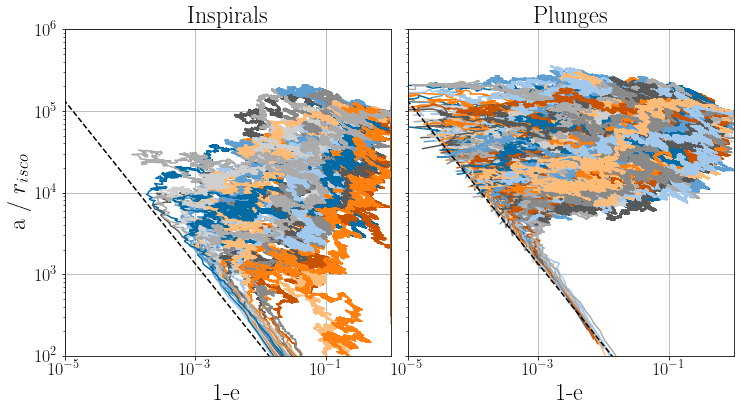

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharex='all', sharey='all')

evs_example = load(runs, 1e5*hs.r_isco)
preprocess(evs_example)
insp, plunge, other = count(evs_example, ax_insp=axs[0], ax_plunge=axs[1], rasterized=True) # rasterized, otherwise the file is too large

for ax in axs:
    e_grid = 1.-np.array(ax.get_xlim())
    ax.plot(1.-e_grid, 8./6./(1.-e_grid), linestyle='--', color='black')
    ax.grid()
    #ax.set_ylim(bottom=1e1)

axs[0].set_xlim(left=1e-5, right=1)
axs[0].set_ylim(bottom=1e2, top=1e6)
fig.subplots_adjust(wspace=0.05)
axs[0].set_xlabel("1-e"); axs[0].set_ylabel("a / $r_{isco}$"); axs[0].set_title("Inspirals")
axs[1].set_xlabel("1-e"); axs[1].set_title("Plunges")

#fig.savefig("plots/inspiral_vs_plunge.pdf", bbox_inches='tight')

In [10]:
def n_o_inspirals(runs, a0s):
    """
    Process a list of files and calculate the inspiral fraction for each a_0
    """
    noi = np.zeros(np.shape(a0s))
    no_ip = np.zeros(np.shape(a0s))
    for i,a0 in enumerate(a0s):
        evs = load(runs, a0)
        n = len(evs)
        if n == 0:
            continue
        preprocess(evs)
        insp, plunge, other = count(evs)
        noi[i] = float(insp)/n   
        no_ip[i] = float(insp)/(insp+plunge) if (insp+plunge) > 0 else 0.
        print(i, n, insp, plunge, noi[i], no_ip[i])
    return noi, no_ip

In [11]:
a0s = np.array([1e3, 5e3, 1e4, 5e4, 1e5, 1e6, 1e7])*hs.r_isco
noi, no_ip = n_o_inspirals(runs, a0s)

0 190 164 1 0.8631578947368421 0.9939393939393939
1 190 154 10 0.8105263157894737 0.9390243902439024
2 190 121 33 0.6368421052631579 0.7857142857142857
3 190 52 96 0.2736842105263158 0.35135135135135137
4 190 33 129 0.1736842105263158 0.2037037037037037
5 190 7 140 0.03684210526315789 0.047619047619047616
6 187 0 82 0.0 0.0


In [12]:
noi73, no_ip73 = n_o_inspirals(runs73, a0s)
noi32, no_ip32 = n_o_inspirals(runs32, a0s)

0 100 85 0 0.85 1.0
1 200 161 8 0.805 0.9526627218934911
2 128 93 11 0.7265625 0.8942307692307693
3 107 36 52 0.3364485981308411 0.4090909090909091
4 100 17 63 0.17 0.2125
5 29 0 18 0.0 0.0
0 100 87 0 0.87 1.0
1 66 52 1 0.7878787878787878 0.9811320754716981
2 100 61 20 0.61 0.7530864197530864
3 98 36 44 0.3673469387755102 0.45
4 66 14 37 0.21212121212121213 0.27450980392156865
5 9 0 4 0.0 0.0


In [13]:
# Calculate a_c
kappa = ((1.+stellarHalo.alpha)**(3./2.) *(3-stellarHalo.alpha) 
             * stellarDiffusion.CoulombLogarithm)
f = 0.1
x_ibco = 8.
a_c = 5.8e-3 * r_st * (x_ibco/8.)**(-2) * (1.)**(4./5) * (f*kappa)**(-4./5)

print(kappa, a_c, a_c/hs.r_isco)

60.40557436740666 0.0002753969106895318 9562.39273227541


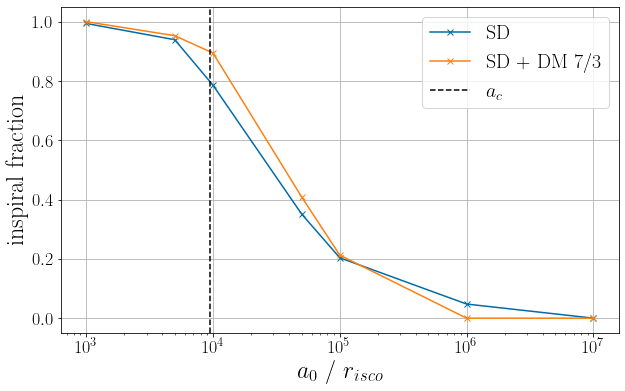

In [14]:
plt.figure(figsize=(10,6))

plt.plot(a0s / hs.r_isco, no_ip, marker='x', label = "SD")
plt.plot(a0s / hs.r_isco, no_ip73, marker='x', label = "SD + DM 7/3")
#plt.plot(a0s / hs.r_isco, no_ip32, marker='x', label = "SD + DM 3/2")

plt.axvline(a_c/hs.r_isco, linestyle='--', color='black', label="$a_c$")
plt.xscale('log')
plt.xlabel("$a_0$ / $r_{isco}$")
plt.ylabel("inspiral fraction")

plt.grid()
plt.legend()
#plt.savefig("plots/inspiral_fraction.pdf", bbox_inches='tight')